we still seem to be getting bad results over baseline even with a completely disjoint network. could the regression just be going off of the frequencies when making predictions? we will test this by generating completely random features for each of the concepts in lieu of actually using the deepwalk embeddings

In [1]:
import pandas as pd
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

import seaborn as sns

In [2]:
%matplotlib inline

## Constant definition

In [3]:
vecsize = 64
num_nodes = 7927

---

In [4]:
def make_fake_features(vecsize, n_uids):
    # embeddings are gaussian distributed on each feature column
    # maybe a cauchy distribution? or power normal
    
    features = [
        np.random.standard_normal(n_uids)
        for i in range(vecsize)
    ]
    
    cols = ["f{}".format(i) for i in range(vecsize)]
    
    return (pd
        .DataFrame(np.transpose(features), columns=cols)
        .reset_index()
        .rename(columns={"index": "uid"})
    )

In [5]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

In [6]:
def eval_performance(idx, vecsize):
    
    train = pd.read_csv(
        "data/min_hetionet/test/train_{}.tsv".format(idx), sep='\t'
    )
    
    holdout = pd.read_csv(
        "data/min_hetionet/test/holdout_{}.tsv".format(idx), sep='\t'
    )
    
    features = make_fake_features(vecsize, num_nodes)
    
    
    
    
    # train the model
    
    tmp = convolv_features(train, features, vecsize, "inner")

    feat_cols = ["conv{}".format(j) for j in range(vecsize)]
    regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

    # test on holdout
    test = convolv_features(
        holdout.drop("etype", axis=1),
        features, vecsize, "left"
    )

    assert len(test) == len(holdout)

    # if there are empty ones in the features column,
    # then we didn't generate any embeddings, and therefore
    # need to split those up and treat as zeroes
    # for the others we can predict normally, then join together

    regular = test[test["conv0"].notnull()].assign(missed = False)

    missed = (test[test["conv0"].isnull()]
        .assign(
            predval = 0
        )
        .assign(missed = True)
    )
    
    print("predicted {} missed {}".format(len(regular), len(missed)))

    # add in predictions
    ans = regular.assign(
        predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
    )

    ans = ans.append(missed)

    assert len(ans) == len(holdout)

    return (ans
        [["chemical_uid", "disease_uid", "predval", "missed"]]
        .merge(
            holdout[["chemical_uid", "disease_uid", "etype"]],
            how="inner", on=["chemical_uid", "disease_uid"]
        )
        .sort_values("predval", ascending=False)
        .reset_index(drop=True)
    )

---

## Train the model

predicted 5993 missed 0
predicted 6476 missed 0
predicted 6538 missed 0
predicted 5421 missed 0
predicted 5758 missed 0


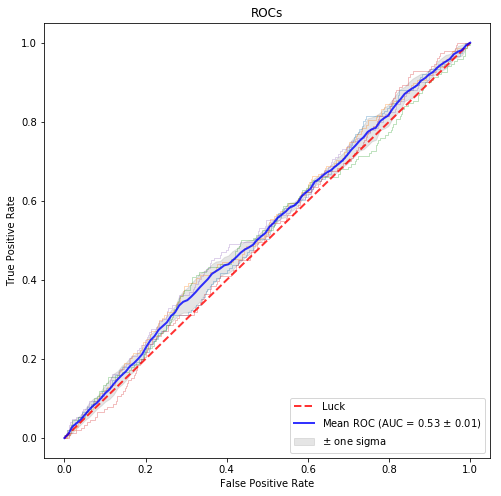

In [7]:
K = 5

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 8))

for idx in range(K):
    res = eval_performance(idx, vecsize)

    fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0
    auc_val = auc(fpr, tpr)
    aucs.append(auc_val)

    plt.plot(fpr, tpr, lw=1, alpha=0.3)
    
# ---------------    
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr, mean_tpr, color='b',
    label="Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2, alpha=0.8
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper, color='grey',
    alpha=0.2, label="$\pm$ one sigma"
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROCs")
          
plt.legend(loc="lower right")
plt.show()

so when we use the same training and regression code on a consistent set of randomly generated embeddings, we see what we want which is a 0.5 roc value. however we do not seem to be able to get the same 0.5 roc when we are using embeddings generated by deepwalk even when the nodes are not linked in any way. this is most strange, and suggests that deepwalk is clustering nodes somehow in the embedding?